<center><h1>MISHRA_PRATEET_FINAL_PROJECT</h1></center>

Name: PRATEET MISHRA
<br>
Github Username: PrateetMishraUSC
<br>
USC ID: 9074068892

# 1. Transfer Learning for Image Classification

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16

## 1. (a) After Importing libraries, build a classifier that distinguishes images of six scenes.

## 1. (b) Data Exploration and Pre-processing

In [2]:
train_dir = '../data/seg_train'
test_dir = '../data/seg_test'

In [3]:
image_size = (150, 150)
batch_size = 32
def getting_paths_and_labels(directory, img_size, model):
    file_paths = []
    labels = []
    images = []

    class_names = sorted(os.listdir(directory))  
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                file_paths.append(file_path)
                labels.append(label)
                
                img = load_img(file_path, target_size=img_size)
                img_array = img_to_array(img)
                images.append(img_array)

    images = np.array(images)
    labels = np.array(labels)

    images = preprocessing_images(images, model)

    return images, labels, class_names

In [4]:
def preprocessing_images(images, model):
    if model in ["ResNet50", "ResNet101"]:
        return preprocess_resnet(images)
    elif model == "EfficientNetB0":
        return preprocess_efficientnet(images)
    elif model == "VGG16":
        return preprocess_vgg16(images)
    else:
        raise ValueError(f"Unknown model name: {model}")

In [5]:
model_name_50 = "ResNet50"
training_images, training_labels, class_names = getting_paths_and_labels(train_dir, image_size, model_name_50)
test_images, test_labels, class_names = getting_paths_and_labels(test_dir, image_size, model_name_50)

In [6]:
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [7]:
print(len(training_images))

14034


### Label Encoding

In [8]:
encoder = LabelEncoder()
training_labels_encoded = encoder.fit_transform(training_labels)
test_labels_encoded = encoder.fit_transform(test_labels)

### Splitting the training dataset into 80% training and 20% validation set

In [9]:
xTrain, yTrain, xTest, yTest = train_test_split(
    training_images, training_labels_encoded, test_size=0.2, random_state=42, stratify=training_labels_encoded)

In [10]:
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(11227, 150, 150, 3)
(2807, 150, 150, 3)
(11227,)
(2807,)


### One Hot Encoding 

In [10]:
training_labels_with_one_hot_encoding = tf.keras.utils.to_categorical(xTest, num_classes=6)
validation_labels_with_one_hot_encoding = tf.keras.utils.to_categorical(yTest, num_classes=6)
test_labels_one_hot_encoding = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=6)

### Initializing training and validation dataset 

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((xTrain, training_labels_with_one_hot_encoding)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((yTrain, validation_labels_with_one_hot_encoding)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Early Stopping

In [12]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=50
)

## 1. (c) Transfer Learning

### 1. (c) (ii) To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),           
    layers.RandomTranslation(0.1, 0.1),   
    layers.RandomZoom(0.1),               
    layers.RandomFlip("vertical"),
    layers.RandomContrast(0.1),            
],name="data_augmentation")

### 1. (c) (i) When dealing with classification of relatively small image datasets, deep net- works may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those fea- tures can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement lay- ers. In this project, you will use pre-trained models ResNet50, ResNet100, EfficientNetB0 and VGG16. For those pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

### AND

### 1. (c) (iii) Use ReLU activation functions in the last layer and a softmax layer, along with regularization, batch normalization, and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss

In [14]:
def model_with_layers(model_name):
    if model_name == "ResNet50":
        pretrained_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')
    elif model_name == "ResNet101":
        pretrained_model = ResNet101(include_top=False, pooling='avg', weights='imagenet')
    elif model_name == "EfficientNetB0":
        pretrained_model = EfficientNetB0(include_top=False, pooling='avg', weights='imagenet')
    elif model_name == "VGG16":
        pretrained_model = VGG16(include_top=False, pooling='avg', weights='imagenet')
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    for layer in pretrained_model.layers:
            layer.trainable=False

    model = models.Sequential([
    data_augmentation,
    pretrained_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax', kernel_regularizer=l2(0.001))
    ])
    
    model.build(input_shape=(None, 150, 150, 3))

    model.summary()
    
    model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy', 'precision', 'recall', 'f1_score', 'auc'])

    return model

### 1. (c) (iv) Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs

In [15]:
def get_history_and_fit_model(model):
    his = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[early_stopping]
    )
    return his
    
def plotting_the_curves(his):
    training_loss = his.history['loss']
    validation_loss = his.history['val_loss']
    
    training_accuracy = his.history.get('accuracy')
    validation_accuracy = his.history.get('val_accuracy')
    
    epochs_range = range(1, len(training_loss) + 1)
    
    plt.figure(figsize=(8, 4))
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss', linestyle='--')
    plt.title('Training and Validation Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(8, 4))
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy', linestyle='--')
    plt.title('Training and Validation Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

def get_test_loss_and_accuracy_with_all_scores(model, model_name):
    test_values = model.evaluate(test_images, test_labels_one_hot_encoding, batch_size=batch_size, verbose=1)

    test_loss = test_values[0]
    test_accuracy = test_values[1]
    
    print(f"Test Loss \033[1m{model_name}\033[0m: {test_loss:.4f}")
    print(f"Test Accuracy \033[1m{model_name}\033[0m: {test_accuracy:.4f}")

    test_predictions = model.predict(test_images, batch_size=batch_size, verbose=1)

    test_pred_classes = np.argmax(test_predictions, axis=1) 
    
    true_classes = np.argmax(test_labels_one_hot_encoding, axis=1)  
    
    precision = precision_score(true_classes, test_pred_classes, average='weighted')
    recall = recall_score(true_classes, test_pred_classes, average='weighted')
    f1 = f1_score(true_classes, test_pred_classes, average='weighted')
    auc = roc_auc_score(test_labels_one_hot_encoding, test_predictions, multi_class='ovr')
    print(f"\n----------For \033[1m{model_name}\033[0m Model----------\n")
    
    results = pd.DataFrame({
        "Metric": ["Precision", "Recall", "F1 Score", "AUC"],
        "Score": [precision, recall, f1, auc]
    })
    
    print(results)
    
    print("\nClassification Report:")
    print(classification_report(true_classes, test_pred_classes, target_names=class_names))

    return test_loss, test_accuracy, precision, recall, f1, auc

### Now we will be performing all the above steps for all the 4 models. 

#### ResNet50 Model (Already performed few steps above specifically for this model)

In [16]:
model_res50 = model_with_layers("ResNet50")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,641,926 (94.00 MB)

 Trainable params: 1,053,190 (4.02 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

In [17]:
history_res50 = get_history_and_fit_model(model_res50)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 113s 313ms/step - accuracy: 0.6518 - auc: 0.8990 - f1_score: 0.6505 - loss: 1.8258 - precision: 0.7018 - recall: 0.5920 - val_accuracy: 0.8500 - val_auc: 0.9799 - val_f1_score: 0.8509 - val_loss: 1.2231 - val_precision: 0.8626 - val_recall: 0.8408
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 109s 312ms/step - accuracy: 0.7916 - auc: 0.9653 - f1_score: 0.7924 - loss: 1.3809 - precision: 0.8184 - recall: 0.7683 - val_accuracy: 0.8404 - val_auc: 0.9776 - val_f1_score: 0.8391 - val_loss: 1.2392 - val_precision: 0.8533 - val_recall: 0.8333
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 110s 314ms/step - accuracy: 0.8190 - auc: 0.9736 - f1_score: 0.8197 - loss: 1.2670 - precision: 0.8394 - recall: 0.7973 - val_accuracy: 0.8700 - val_auc: 0.9828 - val_f1_score: 0.8715 - val_loss: 1.1268 - val_precision: 0.8808 - val_recall: 0.8636
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 113s 321ms/step - accuracy: 0.8278 - auc: 0.9761 - f1_score: 0.8285 - loss: 1.2112 - precisi

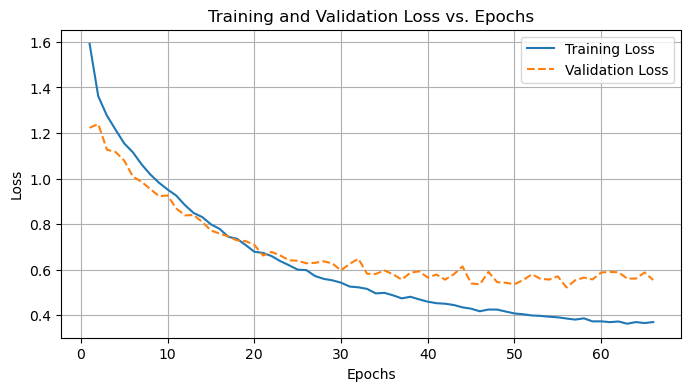

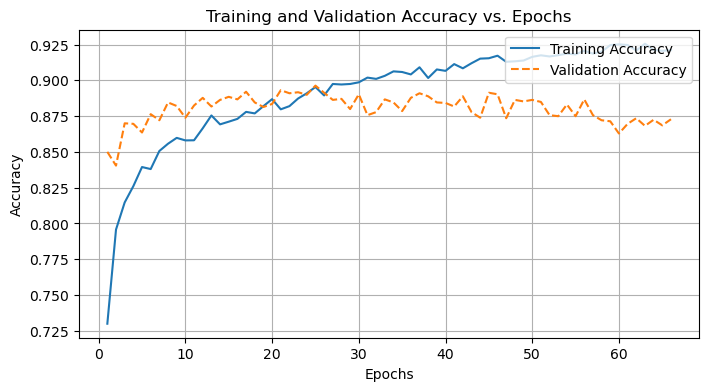

In [18]:
plotting_the_curves(history_res50)

In [19]:
test_loss_res50, test_accuracy_res50, precision_res50, recall_res50, f1_res50, auc_res50 = get_test_loss_and_accuracy_with_all_scores(model_res50, "ResNet50")

94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.8921 - auc: 0.9851 - f1_score: 0.5373 - loss: 0.5007 - precision: 0.8988 - recall: 0.8886
Test Loss ResNet50: 0.5403
Test Accuracy ResNet50: 0.8803
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step

----------For ResNet50 Model----------

      Metric     Score
0  Precision  0.879674
1     Recall  0.880333
2   F1 Score  0.879559
3        AUC  0.984165

Classification Report:
              precision    recall  f1-score   support

   buildings       0.90      0.91      0.91       437
      forest       0.97      0.99      0.98       474
     glacier       0.83      0.76      0.79       553
    mountain       0.78      0.81      0.79       525
         sea       0.90      0.94      0.92       510
      street       0.92      0.91      0.91       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



#### ResNet101

In [20]:
model_name_50 = "ResNet101"
training_images, training_labels, class_names = getting_paths_and_labels(train_dir, image_size, model_name_50)
test_images, test_labels, class_names = getting_paths_and_labels(test_dir, image_size, model_name_50)

In [21]:
encoder = LabelEncoder()
training_labels_encoded = encoder.fit_transform(training_labels)
test_labels_encoded = encoder.fit_transform(test_labels)

In [22]:
xTrain, yTrain, xTest, yTest = train_test_split(
    training_images, training_labels_encoded, test_size=0.2, random_state=42, stratify=training_labels_encoded)

In [23]:
training_labels_with_one_hot_encoding = tf.keras.utils.to_categorical(xTest, num_classes=6)
validation_labels_with_one_hot_encoding = tf.keras.utils.to_categorical(yTest, num_classes=6)
test_labels_one_hot_encoding = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=6)

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((xTrain, training_labels_with_one_hot_encoding)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((yTrain, validation_labels_with_one_hot_encoding)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [25]:
model_res101 = model_with_layers("ResNet101")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 2048)           │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,712,390 (166.75 MB)

 Trainable params: 1,053,190 (4.02 MB)

 Non-trainable params: 42,659,200 (162.73 MB)

In [26]:
history_res101 = get_history_and_fit_model(model_res101)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 208s 578ms/step - accuracy: 0.6509 - auc: 0.9044 - f1_score: 0.6492 - loss: 1.8093 - precision: 0.7032 - recall: 0.5910 - val_accuracy: 0.8408 - val_auc: 0.9764 - val_f1_score: 0.8405 - val_loss: 1.2765 - val_precision: 0.8565 - val_recall: 0.8251
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 198s 564ms/step - accuracy: 0.7929 - auc: 0.9656 - f1_score: 0.7929 - loss: 1.3775 - precision: 0.8189 - recall: 0.7646 - val_accuracy: 0.8450 - val_auc: 0.9800 - val_f1_score: 0.8456 - val_loss: 1.2184 - val_precision: 0.8542 - val_recall: 0.8351
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 198s 563ms/step - accuracy: 0.8131 - auc: 0.9704 - f1_score: 0.8140 - loss: 1.2973 - precision: 0.8357 - recall: 0.7874 - val_accuracy: 0.8247 - val_auc: 0.9753 - val_f1_score: 0.8190 - val_loss: 1.2601 - val_precision: 0.8372 - val_recall: 0.8169
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 197s 562ms/step - accuracy: 0.8266 - auc: 0.9761 - f1_score: 0.8270 - loss: 1.2189 - precisi

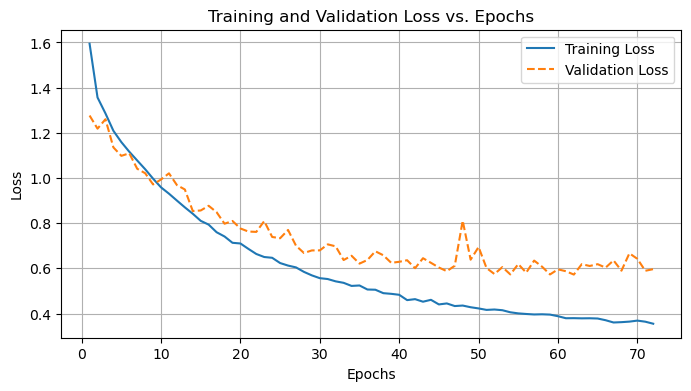

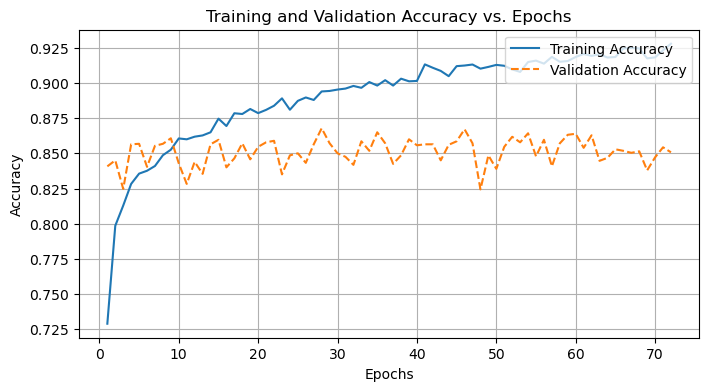

In [27]:
plotting_the_curves(history_res101)

In [28]:
test_loss_res101, test_accuracy_res101, precision_res101, recall_res101, f1_res101, auc_res101 = get_test_loss_and_accuracy_with_all_scores(model_res101, "ResNet101")

94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - accuracy: 0.8770 - auc: 0.9847 - f1_score: 0.5287 - loss: 0.5125 - precision: 0.8837 - recall: 0.8701
Test Loss ResNet101: 0.5677
Test Accuracy ResNet101: 0.8637
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 450ms/step

----------For ResNet101 Model----------

      Metric     Score
0  Precision  0.863195
1     Recall  0.863667
2   F1 Score  0.861547
3        AUC  0.982191

Classification Report:
              precision    recall  f1-score   support

   buildings       0.89      0.89      0.89       437
      forest       0.98      0.98      0.98       474
     glacier       0.75      0.79      0.77       553
    mountain       0.82      0.66      0.73       525
         sea       0.88      0.97      0.92       510
      street       0.88      0.91      0.90       501

    accuracy                           0.86      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.86      0.86      0.86      3000



#### EfficientNetB0

In [97]:
model_name_50 = "EfficientNetB0"
training_images, training_labels, class_names = getting_paths_and_labels(train_dir, image_size, model_name_50)
test_images, test_labels, class_names = getting_paths_and_labels(test_dir, image_size, model_name_50)

In [99]:
encoder = LabelEncoder()
training_labels_encoded = encoder.fit_transform(training_labels)
test_labels_encoded = encoder.fit_transform(test_labels)

In [101]:
xTrain, yTrain, xTest, yTest = train_test_split(
    training_images, training_labels_encoded, test_size=0.2, random_state=42, stratify=training_labels_encoded)

In [102]:
training_labels_with_one_hot_encoding = tf.keras.utils.to_categorical(xTest, num_classes=6)
validation_labels_with_one_hot_encoding = tf.keras.utils.to_categorical(yTest, num_classes=6)
test_labels_one_hot_encoding = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=6)

In [103]:
train_ds = tf.data.Dataset.from_tensor_slices((xTrain, training_labels_with_one_hot_encoding)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((yTrain, validation_labels_with_one_hot_encoding)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [106]:
model_EnB0 = model_with_layers("EfficientNetB0")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,710,569 (17.97 MB)

 Trainable params: 659,974 (2.52 MB)

 Non-trainable params: 4,050,595 (15.45 MB)

In [109]:
history_EnB0 = get_history_and_fit_model(model_EnB0)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 47s 121ms/step - accuracy: 0.6880 - auc: 0.9149 - f1_score: 0.6876 - loss: 1.6412 - precision: 0.7420 - recall: 0.6294 - val_accuracy: 0.8860 - val_auc: 0.9885 - val_f1_score: 0.8869 - val_loss: 1.0467 - val_precision: 0.9003 - val_recall: 0.8685
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.8345 - auc: 0.9781 - f1_score: 0.8350 - loss: 1.1763 - precision: 0.8478 - recall: 0.8172 - val_accuracy: 0.8874 - val_auc: 0.9896 - val_f1_score: 0.8880 - val_loss: 1.0081 - val_precision: 0.8957 - val_recall: 0.8810
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.8640 - auc: 0.9837 - f1_score: 0.8645 - loss: 1.0779 - precision: 0.8782 - recall: 0.8522 - val_accuracy: 0.8945 - val_auc: 0.9907 - val_f1_score: 0.8956 - val_loss: 0.9675 - val_precision: 0.9053 - val_recall: 0.8892
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - accuracy: 0.8681 - auc: 0.9854 - f1_score: 0.8685 - loss: 1.0353 - precision: 

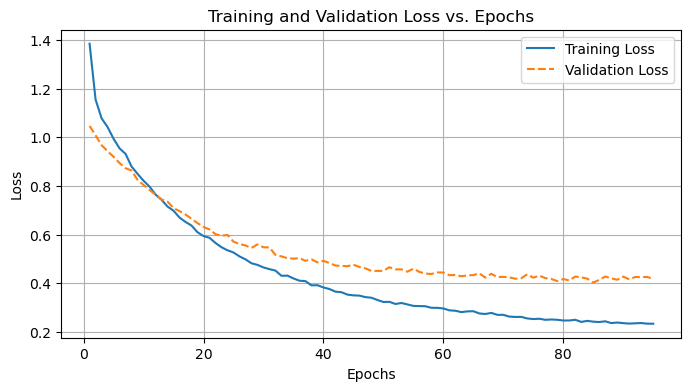

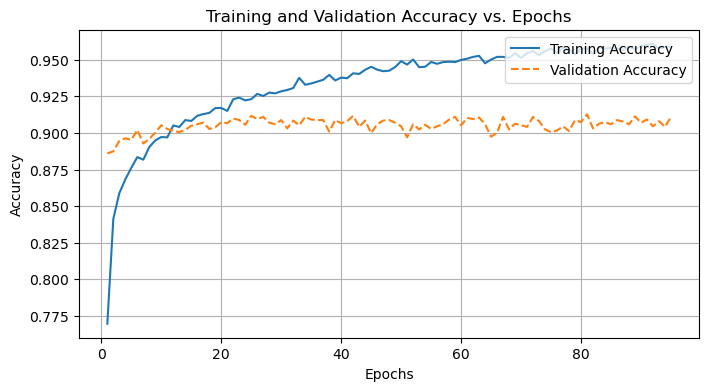

In [111]:
plotting_the_curves(history_EnB0)

In [113]:
test_loss_EnB0, test_accuracy_EnB0, precision_EnB0, recall_EnB0, f1_EnB0, auc_EnB0 = get_test_loss_and_accuracy_with_all_scores(model_EnB0, "EfficientNetB0")

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9094 - auc: 0.9885 - f1_score: 0.5498 - loss: 0.4094 - precision: 0.9112 - recall: 0.9087
Test Loss EfficientNetB0: 0.4397
Test Accuracy EfficientNetB0: 0.9023
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step

----------For EfficientNetB0 Model----------

      Metric     Score
0  Precision  0.901998
1     Recall  0.902333
2   F1 Score  0.901972
3        AUC  0.989722

Classification Report:
              precision    recall  f1-score   support

   buildings       0.90      0.91      0.90       437
      forest       0.99      0.99      0.99       474
     glacier       0.84      0.83      0.83       553
    mountain       0.87      0.83      0.85       525
         sea       0.91      0.95      0.93       510
      street       0.92      0.91      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



#### VGG16

In [38]:
model_name_50 = "VGG16"
training_images, training_labels, class_names = getting_paths_and_labels(train_dir, image_size, model_name_50)
test_images, test_labels, class_names = getting_paths_and_labels(test_dir, image_size, model_name_50)

In [39]:
encoder = LabelEncoder()
training_labels_encoded = encoder.fit_transform(training_labels)
test_labels_encoded = encoder.fit_transform(test_labels)

In [40]:
xTrain, yTrain, xTest, yTest = train_test_split(
    training_images, training_labels_encoded, test_size=0.2, random_state=42, stratify=training_labels_encoded)

In [41]:
training_labels_with_one_hot_encoding = tf.keras.utils.to_categorical(xTest, num_classes=6)
validation_labels_with_one_hot_encoding = tf.keras.utils.to_categorical(yTest, num_classes=6)
test_labels_one_hot_encoding = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=6)

In [42]:
train_ds = tf.data.Dataset.from_tensor_slices((xTrain, training_labels_with_one_hot_encoding)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((yTrain, validation_labels_with_one_hot_encoding)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [43]:
model_VGG16 = model_with_layers("VGG16")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,982,470 (57.15 MB)

 Trainable params: 266,758 (1.02 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [44]:
history_VGG16 = get_history_and_fit_model(model_VGG16)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 287s 810ms/step - accuracy: 0.4744 - auc: 0.7918 - f1_score: 0.4704 - loss: 2.0172 - precision: 0.5409 - recall: 0.3766 - val_accuracy: 0.7239 - val_auc: 0.9251 - val_f1_score: 0.7273 - val_loss: 1.6303 - val_precision: 0.7364 - val_recall: 0.7175
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 281s 801ms/step - accuracy: 0.7227 - auc: 0.9396 - f1_score: 0.7221 - loss: 1.2894 - precision: 0.7588 - recall: 0.6709 - val_accuracy: 0.7955 - val_auc: 0.9501 - val_f1_score: 0.7961 - val_loss: 1.3444 - val_precision: 0.8007 - val_recall: 0.7898
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 281s 801ms/step - accuracy: 0.7482 - auc: 0.9513 - f1_score: 0.7480 - loss: 1.1857 - precision: 0.7839 - recall: 0.7071 - val_accuracy: 0.8048 - val_auc: 0.9566 - val_f1_score: 0.8061 - val_loss: 1.2678 - val_precision: 0.8086 - val_recall: 0.8009
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 281s 801ms/step - accuracy: 0.7595 - auc: 0.9563 - f1_score: 0.7593 - loss: 1.1385 - precisi

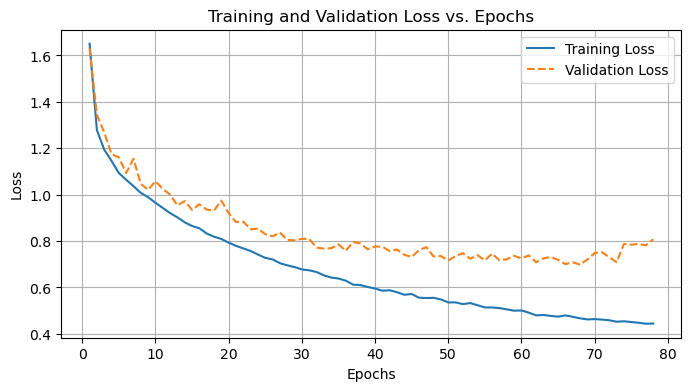

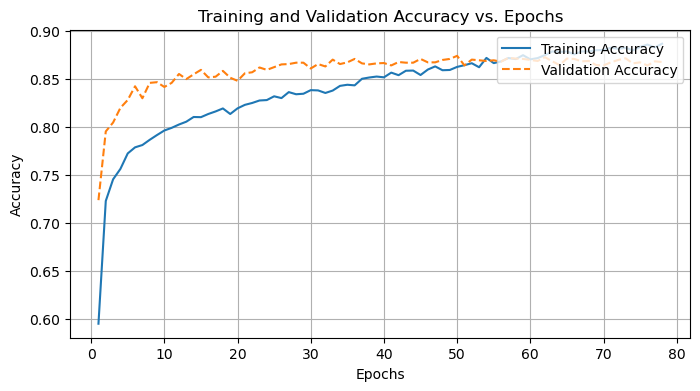

In [45]:
plotting_the_curves(history_VGG16)

In [46]:
test_loss_VGG16, test_accuracy_VGG16, precision_VGG16, recall_VGG16, f1_VGG16, auc_VGG16 = get_test_loss_and_accuracy_with_all_scores(model_VGG16, "VGG16")

94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 634ms/step - accuracy: 0.8764 - auc: 0.9765 - f1_score: 0.5299 - loss: 0.6612 - precision: 0.8805 - recall: 0.8760
Test Loss VGG16: 0.7023
Test Accuracy VGG16: 0.8643
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 631ms/step

----------For VGG16 Model----------

      Metric     Score
0  Precision  0.863516
1     Recall  0.864333
2   F1 Score  0.863692
3        AUC  0.982484

Classification Report:
              precision    recall  f1-score   support

   buildings       0.87      0.87      0.87       437
      forest       0.97      0.98      0.98       474
     glacier       0.78      0.79      0.79       553
    mountain       0.80      0.74      0.77       525
         sea       0.89      0.92      0.91       510
      street       0.89      0.89      0.89       501

    accuracy                           0.86      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.86      0.86      0.86      3000



#### Comparision Table of all models (For Test)

In [158]:
data = {
    "Model": ["VGG16", "EfficientNetB0", "ResNet101", "ResNet50"],
    "Test Loss": [test_loss_VGG16, test_loss_EnB0, test_loss_res101, test_loss_res50],
    "Test Accuracy": [test_accuracy_VGG16, test_accuracy_EnB0, test_accuracy_res101, test_accuracy_res50],
    "Precision": [precision_VGG16, precision_EnB0, precision_res101, precision_res50],
    "Recall": [recall_VGG16, recall_EnB0, recall_res101, recall_res50],
    "F1 Score": [f1_VGG16, f1_EnB0, f1_res101, f1_res50],
    "AUC": [auc_VGG16, auc_EnB0, auc_res101, auc_res50]
}

results_df = pd.DataFrame(data).set_index("Model")
results_df

,Test Loss,Test Accuracy,Precision,Recall,F1 Score,AUC
Model,,,,,,
VGG16,0.702267,0.864333,0.863516,0.864333,0.863692,0.982484
EfficientNetB0,0.439714,0.902333,0.901998,0.902333,0.901972,0.989722
ResNet101,0.567710,0.863667,0.863195,0.863667,0.861547,0.982191
ResNet50,0.540267,0.880333,0.879674,0.880333,0.879559,0.984165


From the above table we can say that **EfficientNetB0 model outperforms other models** by having a low test loss and high test accuracy.

## References

Links:
1) https://keras.io/api/
2) https://www.tensorflow.org/guide/keras
3) https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html
4) https://medium.com/@silvershine1st/transfer-learning-for-cnn-7eed1d8a5305
6) https://stackoverflow.com/questions/60896416/tensorflow-keras-model-how-to-get-the-best-score-from-a-history-object
7) https://stackoverflow.com/questions/56897864/how-do-i-use-input-shape-and-input-tensor-in-transfer-learning-in-keras

GPT Prompts:
1) how to bold in print statement ?
**Response - In Python, you can make text bold in the terminal using ANSI escape codes. The specific escape code for bold text is \033[1m. To reset the text to normal formatting, use \033[0m.
print("\033[1mThis is bold text\033[0m")
print("This is normal text")**

2) train_ds = tf.data.Dataset.from_tensor_slices((xTrain, training_labels_with_one_hot_encoding)).batch(batch_size)
how can i add prefetch in this ?
**Response - To add prefetching to your tf.data pipeline, you can use the prefetch method. Prefetching allows the data pipeline to prepare the next batch of data while the current batch is being processed by the model, reducing idle time and speeding up training.
Here’s how you can modify your train_ds pipeline to include prefetching:
train_ds = tf.data.Dataset.from_tensor_slices((xTrain, training_labels_with_one_hot_encoding)) \.batch(batch_size).prefetch(tf.data.AUTOTUNE)
tf.data.AUTOTUNE: Dynamically determines the optimal number of elements to prefetch based on available system resources.
prefetch: Ensures that data loading and preprocessing for the next batch happen in parallel with model training.**